In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

2023-12-20 19:26:15.408880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-20 19:26:15.408902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
train_dir = '/home/hermit/Документы/IPT-DataAnalysis-course/lab4/train/'
filepaths = []
labels = []
images = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        img = image.load_img(foldpath+'/'+file, target_size=(32, 32))
        images.append(image.img_to_array(img))
images = np.array(images)
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
1,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
2,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
3,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
4,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
...,...,...
4722,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4723,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4724,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4725,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma


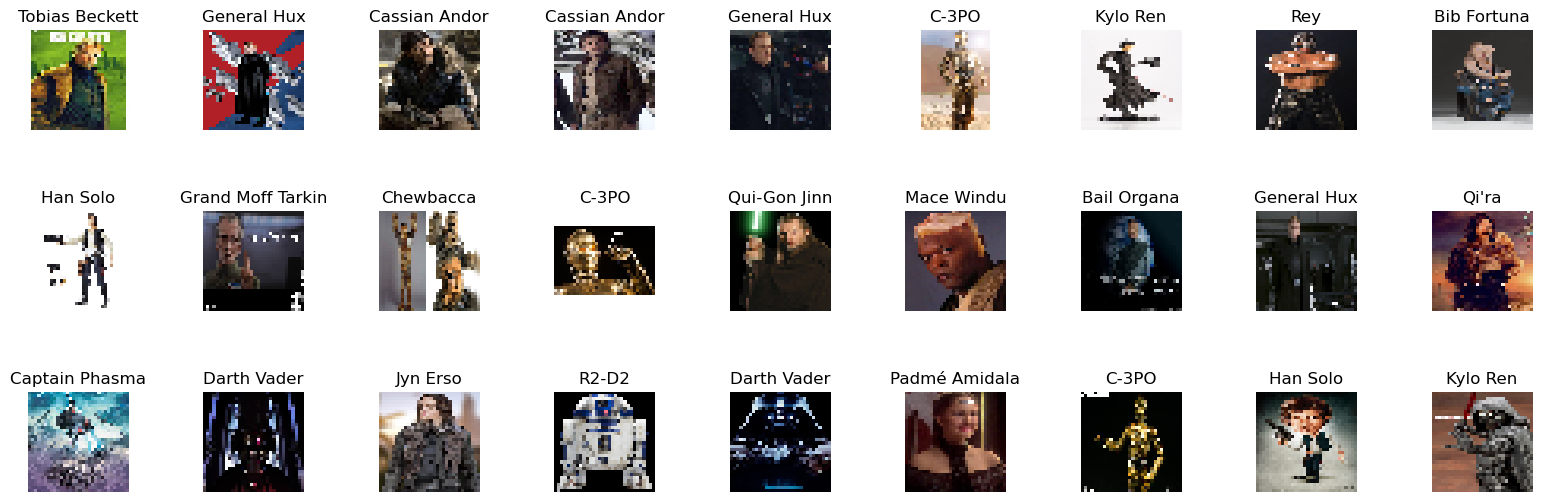

In [5]:
plt.figure(figsize=(20, 6))
plt.rcParams['font.size'] = 10
for i in range(27):
    plt.subplot(3,9,i+1)
    plt.axis('off')
    j = int(np.random.randint(0,images.shape[0],1))
    plt.imshow(images[j]/255)
    plt.title(train_df.labels[j])
    plt.subplots_adjust(hspace=.8)

In [6]:
train_df.labels.value_counts()[:20]

Admiral Ackbar          100
Greedo                   99
Princess Leia Organa     98
Luke Skywalker           98
Wedge Antilles           97
Rey                      97
C-3PO                    97
Chewbacca                96
Kenobi                   96
Jar Jar Binks            96
Dark Sidious             96
Jango Fett               95
Grand Moff Tarkin        95
Yoda                     95
Cassian Andor            95
Captain Phasma           95
Jyn Erso                 95
Nien Nunb                94
Qui-Gon Jinn             94
Poe Dameron              94
Name: labels, dtype: int64

In [7]:
X_train = [images[i] for i in np.where(train_df.labels=='BB-8')][0]

In [8]:
X_train.shape

(91, 32, 32, 3)

In [9]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # normalization [-1, 1]
X_train = np.clip(X_train, -1, 1)

In [10]:
X_train.shape

(91, 32, 32, 3)

In [11]:
from tensorflow.keras.optimizers.legacy import Adam

optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [12]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(layers.Conv2D(128, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(512, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [13]:
latent_dim = 100

def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model  

In [14]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [15]:
def plot_generated_images(epoch, generator):
    num_of_images = 5
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [16]:
discrim_losses = []
generator_losses = []

def train_model(epochs, batch_size):
    d_loss = 0
    gan_loss=0
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise,verbose=0)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)

        if ep % 200 == 0:
            print('epoch: ', ep)
            print(ep, "discriminator loss: ", d_loss,"generator loss: ", gan_loss)
            plot_generated_images(ep, generator)

In [17]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

2023-12-20 19:28:11.680079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-20 19:28:11.680149: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-20 19:28:11.680210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2023-12-20 19:28:11.681328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 512)         1

In [19]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

epoch:  0
0 discriminator loss:  0.6530811786651611
1/1 [==============================] - 0s 216ms/step


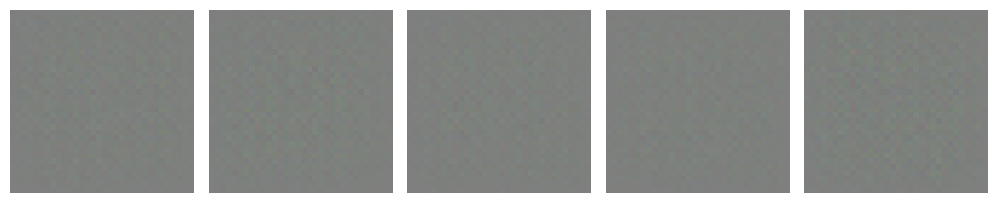

epoch:  200
200 discriminator loss:  0.31371408700942993
1/1 [==============================] - 0s 57ms/step


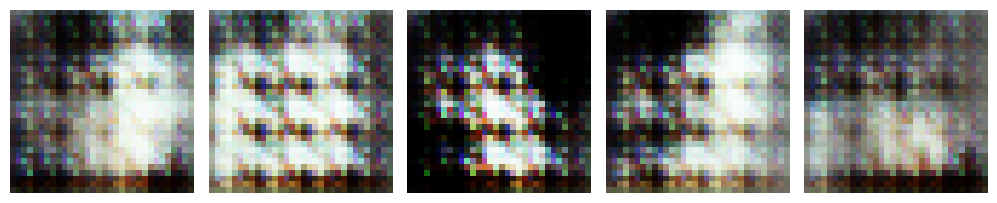

epoch:  400
400 discriminator loss:  0.2481701821088791
1/1 [==============================] - 0s 59ms/step


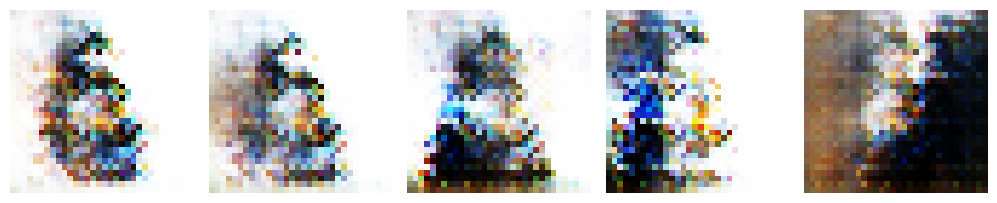

epoch:  600
600 discriminator loss:  0.20500746369361877
1/1 [==============================] - 0s 54ms/step


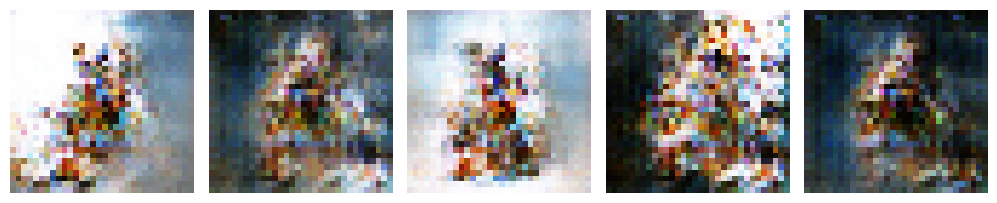

epoch:  800
800 discriminator loss:  0.1985497623682022
1/1 [==============================] - 0s 58ms/step


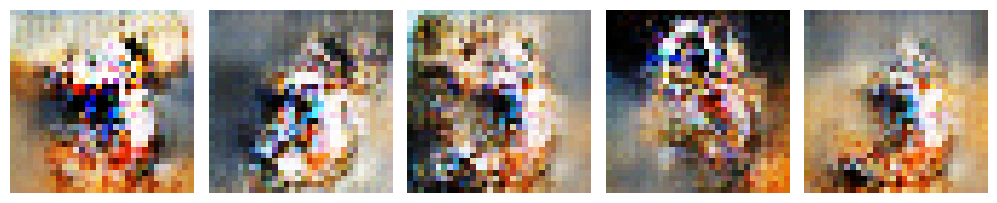

epoch:  1000
1000 discriminator loss:  0.19243904948234558
1/1 [==============================] - 0s 57ms/step


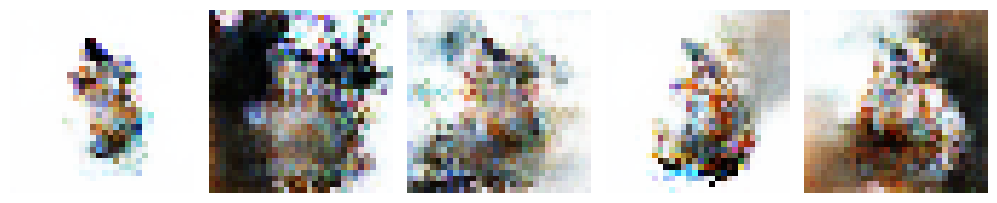

In [20]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 1000 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 32
train_model(epochs, batch_size)

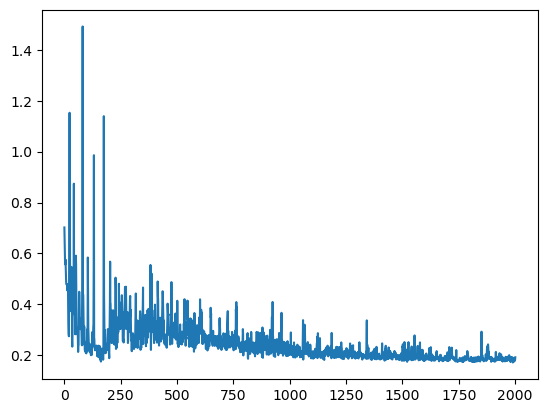

In [21]:
plt.plot(discrim_losses)